#1. Import Libraries and define functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyPDF2
import PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from scipy import signal
import pickle
from time import sleep
from tqdm import tqdm

In [ ]:
def bp(y, fs=40/100, lowcut=.05, highcut=.1, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)

def get_mov_rms(y, fs=40/100, window=150):
    return np.sqrt(signal.convolve(y**2, np.ones(int(fs*window))/int(fs*window), mode='same'))

def get_mov_mean(y, fs=40/100, window=150):
    return signal.convolve(y, np.ones(int(fs*window))/int(fs*window), mode='same')

#2. All files in DonneesB23 data

In [ ]:
# Get list of month and day in dataset
all_folders_month = []
all_folders_day = []
for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for sous_dossier in sous_dossiers:
    path = os.path.join(dossier_actuel, sous_dossier)
    if len(path) == 56:
      all_folders_month.append(path)
    elif len(path) == 67:
      all_folders_day.append(path)

In [ ]:
# prompt: get a dataframe about folders and files fron DonneesB23 data

import pandas as pd

data = []
for root, dirs, files in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for file in files:
    data.append([root, file])

df_allfiles = pd.DataFrame(data, columns=['folder', 'file'])
df_allfiles


,folder,file
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T02_52_05.625000
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_09_47.375000
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_58_44.625000
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_32_19.325000
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_07_53.250000
...,...,...
485,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-10T23_12_34.200000
486,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-10T23_23_59.975000
487,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-10T23_06_42.075000
488,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-08T23_38_59.625000


In [ ]:
df_allfiles.describe()

,folder,file
count,490,490
unique,151,490
top,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T02_52_05.625000
freq,18,1


In [ ]:
# get link of file
all_files = []
for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for fichier in fichiers:
    if fichier[0] == '2':
      path = os.path.join(dossier_actuel, fichier)
      all_files.append(path)
len(all_files)

df_allfiles['file_path'] = all_files

In [ ]:
# prompt: check if data in df_allfiles is duplicates

duplicates = df_allfiles[df_allfiles.duplicated(subset=['file_path'], keep=False)]
if not duplicates.empty:
  print("Duplicate data found:")
  print(duplicates)
else:
  print("No duplicate data found.")


No duplicate data found.


##2.1 Compare Read value methods

###2.1.1 float32

In [ ]:
# Add signal length in second
df_allfiles_float32 = df_allfiles.copy()
for i in tqdm(range(len(df_allfiles_float32))):
    path = df_allfiles_float32.loc[i,'file_path']
    # print(path)
    try:
      y = np.fromfile(path, dtype=np.float32)
      duree_signal = int(len(y))
      df_allfiles_float32.loc[i,'length_signal_sample'] = duree_signal
      df_allfiles_float32.loc[i,'length_signal_second'] = duree_signal/40
      df_allfiles_float32.loc[i, 'positive_values'] = (y > 0).sum()
      df_allfiles_float32.loc[i, 'negative_values'] = (y < 0).sum()
      df_allfiles_float32.loc[i, 'nan_values'] = np.isnan(y).sum()
    except Exception as e:
      print(f"Error processing file {path}: {e}")


100%|██████████| 490/490 [09:53<00:00,  1.21s/it]


In [ ]:
df_allfiles_float32.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   folder                490 non-null    object 
 1   file                  490 non-null    object 
 2   file_path             490 non-null    object 
 3   length_signal_sample  490 non-null    float64
 4   length_signal_second  490 non-null    float64
 5   positive_values       490 non-null    float64
 6   negative_values       490 non-null    float64
 7   nan_values            490 non-null    float64
dtypes: float64(5), object(3)
memory usage: 30.8+ KB


In [ ]:
df_allfiles_float32.head()

,folder,file,file_path,length_signal_sample,length_signal_second,positive_values,negative_values,nan_values
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T02_52_05.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,35200.0,880.0,14175.0,0.0,21025.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_09_47.375000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5118.0,0.0,5634.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_58_44.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,130432.0,3260.8,71130.0,0.0,59301.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_32_19.325000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5742.0,0.0,5010.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_07_53.250000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,118912.0,2972.8,60492.0,0.0,58420.0


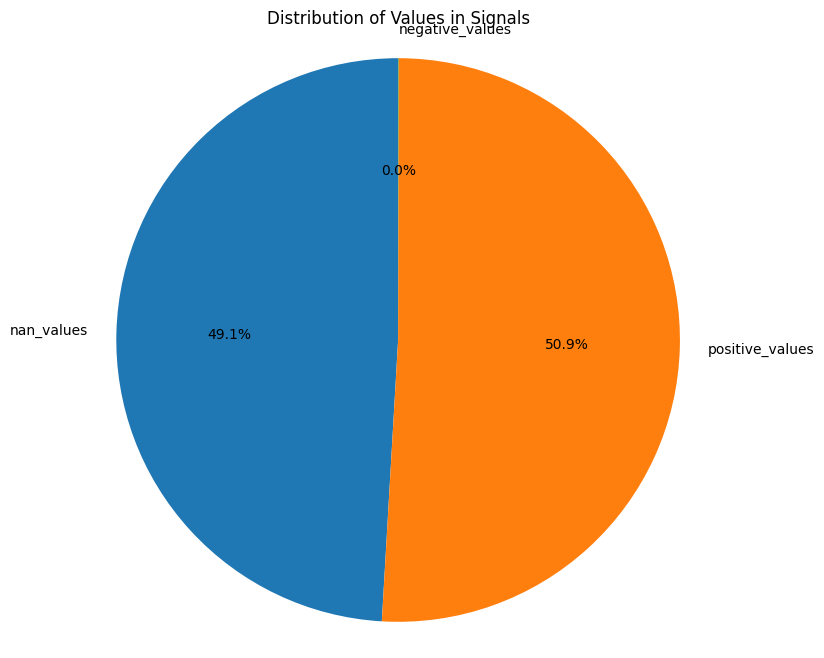

In [ ]:
# prompt: plot nan_values, positive_values, negative_values in pie

import matplotlib.pyplot as plt

# Assuming df_allfiles is your DataFrame

# Extract the relevant columns for the pie chart
values = df_allfiles_float32[['nan_values', 'positive_values', 'negative_values']].sum()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Values in Signals')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


###2.1.2 int32

In [ ]:
# Add signal length in second
df_allfiles_int32 = df_allfiles.copy()
for i in tqdm(range(len(df_allfiles_int32))):
    path = df_allfiles_int32.loc[i,'file_path']
    # print(path)
    try:
      y = np.fromfile(path, dtype=np.int32)
      duree_signal = int(len(y))
      df_allfiles_int32.loc[i,'length_signal_sample'] = duree_signal
      df_allfiles_int32.loc[i,'length_signal_second'] = duree_signal/40
      df_allfiles_int32.loc[i, 'positive_values'] = (y > 0).sum()
      df_allfiles_int32.loc[i, 'negative_values'] = (y < 0).sum()
      df_allfiles_int32.loc[i, 'nan_values'] = np.isnan(y).sum()
    except Exception as e:
      print(f"Error processing file {path}: {e}")

100%|██████████| 490/490 [00:34<00:00, 14.17it/s]


In [ ]:
df_allfiles_int32.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   folder                490 non-null    object 
 1   file                  490 non-null    object 
 2   file_path             490 non-null    object 
 3   length_signal_sample  490 non-null    float64
 4   length_signal_second  490 non-null    float64
 5   positive_values       490 non-null    float64
 6   negative_values       490 non-null    float64
 7   nan_values            490 non-null    float64
dtypes: float64(5), object(3)
memory usage: 30.8+ KB


In [ ]:
df_allfiles_int32.head()

,folder,file,file_path,length_signal_sample,length_signal_second,positive_values,negative_values,nan_values
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T02_52_05.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,35200.0,880.0,14175.0,21025.0,0.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_09_47.375000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5118.0,5634.0,0.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_58_44.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,130432.0,3260.8,71130.0,59301.0,0.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_32_19.325000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5742.0,5010.0,0.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_07_53.250000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,118912.0,2972.8,60492.0,58420.0,0.0


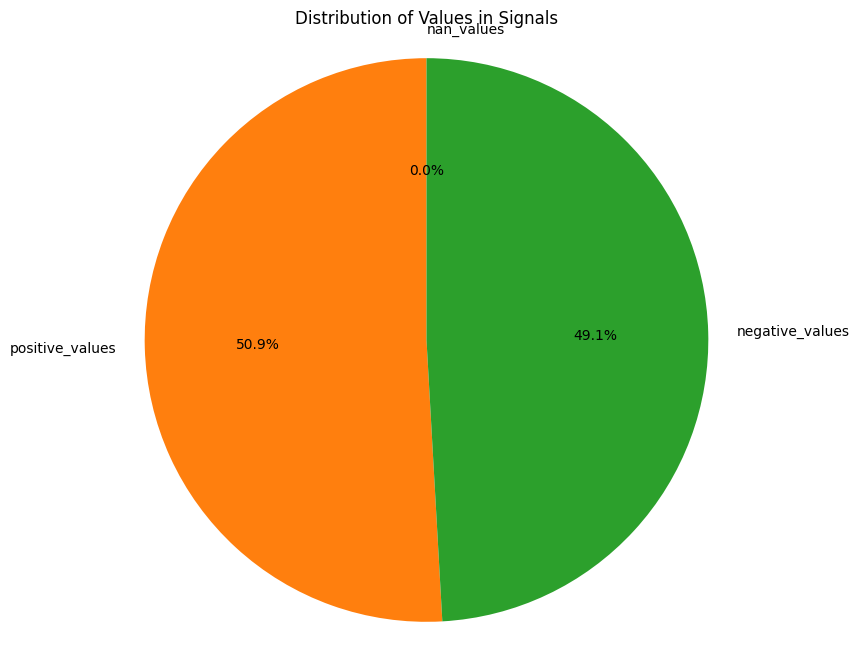

In [ ]:
# prompt: plot nan_values, positive_values, negative_values in pie

import matplotlib.pyplot as plt

# Assuming df_allfiles is your DataFrame

# Extract the relevant columns for the pie chart
values = df_allfiles_int32[['nan_values', 'positive_values', 'negative_values']].sum()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Values in Signals')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# prompt: why use float32 can not read negative values like int32

# The reason why float32 might not read negative values correctly while int32 does could be related to how the data is stored and interpreted.
# Here's a breakdown of the potential issues:
# Data Type Representation:
# - int32: Represents signed integers. It can store both positive and negative numbers within a specific range.
# - float32: Represents floating-point numbers. It can store a wider range of values including fractions and decimals, but might have limitations when dealing with large negative numbers.

# File Format/Endianness:
# - The way the data is stored in the file can impact how it's read by Python's np.fromfile. Different endianness (little-endian or big-endian) or file formats might lead to incorrect interpretation.

# Data Corruption:
# - If there's any corruption or inconsistency in the data file itself, it can cause erroneous readings, irrespective of the data type used for reading.

# Numerical Limits:
# - Float32 may have a specific range for negative values which might not be able to handle the numbers in the file correctly.

# To investigate further:

# 1. Print the first few elements:
# print(y[:10])


# 2. Check for data types in the file:

# 3. Print the Range of values for float32:
# print(np.finfo(np.float32).min, np.finfo(np.float32).max)
# print(np.iinfo(np.int32).min, np.iinfo(np.int32).max)


# 4. Test specific files:
# Try to analyze the problem only for specific files, if you have specific files that are not read correctly.


# In conclusion, the way the data is stored and interpreted can affect how it's read by np.fromfile. Float32 might have limitations in its range or interpretation of negative numbers as opposed to int32, potentially due to its storage and the file format or corruption.




###2.1.3 An Example

In [ ]:
y_int32 = np.fromfile(file='/content/drive/MyDrive/MERMAIDAI/data/DonneesB23/2018-09/2018-09-15/2018-09-15T15_22_36.400000', dtype=np.int32)
y_int32

array([-1535472, -1461440, -1376512, ...,  2667024,  2672624,  2680688],
      dtype=int32)

In [ ]:
y_float32 = np.fromfile(file='/content/drive/MyDrive/MERMAIDAI/data/DonneesB23/2018-09/2018-09-15/2018-09-15T15_22_36.400000', dtype=np.float32)
y_float32

array([         nan,          nan,          nan, ..., 3.737297e-39,
       3.745144e-39, 3.756444e-39], dtype=float32)

In [ ]:
y_ = np.fromfile(file='/content/drive/MyDrive/MERMAIDAI/data/DonneesB23/2018-09/2018-09-15/2018-09-15T15_22_36.400000')
y_

array([-1.44378413e+308, -1.57727524e+308, -1.70789986e+308, ...,
        6.62008364e-308,  6.86867969e-308,  6.92666959e-308])

In [ ]:
type(y[0])

numpy.int32

In [ ]:
y_float64 = np.fromfile(file='/content/drive/MyDrive/MERMAIDAI/data/DonneesB23/2018-09/2018-09-15/2018-09-15T15_22_36.400000', dtype=np.float64)
y_float64

array([-1.44378413e+308, -1.57727524e+308, -1.70789986e+308, ...,
        6.62008364e-308,  6.86867969e-308,  6.92666959e-308])

In [ ]:
# prompt: count number of nan values of y_, y_int32, y_float32, y_float64

nan_count_y_ = np.isnan(y_).sum()
nan_count_y_int32 = np.isnan(y_int32).sum()
nan_count_y_float32 = np.isnan(y_float32).sum()
nan_count_y_float64 = np.isnan(y_float64).sum()

print(f"NaN count in y_: {nan_count_y_}" f"/ {len(y_)}" )
print(f"NaN count in y_int32: {nan_count_y_int32}" f"/ {len(y_int32)}")
print(f"NaN count in y_float32: {nan_count_y_float32}" f"/ {len(y_float32)}")
print(f"NaN count in y_float64: {nan_count_y_float64}" f"/ {len(y_float64)}")


NaN count in y_: 550811/ 2335424
NaN count in y_int32: 0/ 4670848
NaN count in y_float32: 2310071/ 4670848
NaN count in y_float64: 550811/ 2335424


##2.2 EDA

In [ ]:
# prompt: add a column to save the length of each signal read from file_path

# ###2.1.1 int32
# Add signal length in second
df_allfiles_int32 = df_allfiles.copy()
for i in tqdm(range(len(df_allfiles_int32))):
    path = df_allfiles_int32.loc[i,'file_path']
    # print(path)
    try:
      y = np.fromfile(path, dtype=np.int32)
      duree_signal = int(len(y))
      df_allfiles_int32.loc[i,'length_signal_sample'] = duree_signal
      df_allfiles_int32.loc[i,'length_signal_second'] = duree_signal/40
      df_allfiles_int32.loc[i, 'positive_values'] = (y > 0).sum()
      df_allfiles_int32.loc[i, 'negative_values'] = (y < 0).sum()
      df_allfiles_int32.loc[i, 'nan_values'] = np.isnan(y).sum()
    except Exception as e:
      print(f"Error processing file {path}: {e}")

df_allfiles_int32.info()
df_allfiles_int32.head()

100%|██████████| 490/490 [00:26<00:00, 18.38it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   folder                490 non-null    object 
 1   file                  490 non-null    object 
 2   file_path             490 non-null    object 
 3   length_signal_sample  490 non-null    float64
 4   length_signal_second  490 non-null    float64
 5   positive_values       490 non-null    float64
 6   negative_values       490 non-null    float64
 7   nan_values            490 non-null    float64
dtypes: float64(5), object(3)
memory usage: 30.8+ KB


,folder,file,file_path,length_signal_sample,length_signal_second,positive_values,negative_values,nan_values
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T02_52_05.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,35200.0,880.0,14175.0,21025.0,0.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_09_47.375000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5118.0,5634.0,0.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_58_44.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,130432.0,3260.8,71130.0,59301.0,0.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T05_32_19.325000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10752.0,268.8,5742.0,5010.0,0.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-01-06T03_07_53.250000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,118912.0,2972.8,60492.0,58420.0,0.0


In [ ]:
df_allfiles = df_allfiles_int32

In [ ]:
# prompt: sum of length signal in hours

total_length_signal = df_allfiles['length_signal_second'].sum()
print(total_length_signal/3600)
#7031.638222222222

7031.638222222222


In [ ]:
# prompt: sum of length signal in hours of files which have length signal more than 30s

total_length_signal_more_than_30s = df_allfiles[df_allfiles['length_signal_second'] > 30]['length_signal_second'].sum()
print(total_length_signal_more_than_30s/3600)
#7031.638222222223

7031.638222222223


In [ ]:
# prompt: how many signal have length less than 30

number_of_signals_less_than_30 = len(df_allfiles[df_allfiles['length_signal_second'] < 30])
print(number_of_signals_less_than_30)
#2

2


In [ ]:
# prompt: how many signal have length 0

len(df_allfiles[df_allfiles['length_signal_second'] == 0])
#2

2

In [ ]:
# prompt: which signal have signal_length_sample = 0

df_allfiles[df_allfiles['length_signal_sample'] == 0]
#141 and 157

,folder,file,file_path,length_signal_sample,length_signal_second,positive_values,negative_values,nan_values
141,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-12T01_04_19.025000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,0.0,0.0,0.0,0.0,0.0
157,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-10T19_34_26.625000,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,0.0,0.0,0.0,0.0,0.0


In [ ]:
# prompt: remove signal have signal_length_sample = 0

df_allfiles = df_allfiles[df_allfiles['length_signal_sample'] != 0]


In [ ]:
df_allfiles = df_allfiles.reset_index(drop=True)

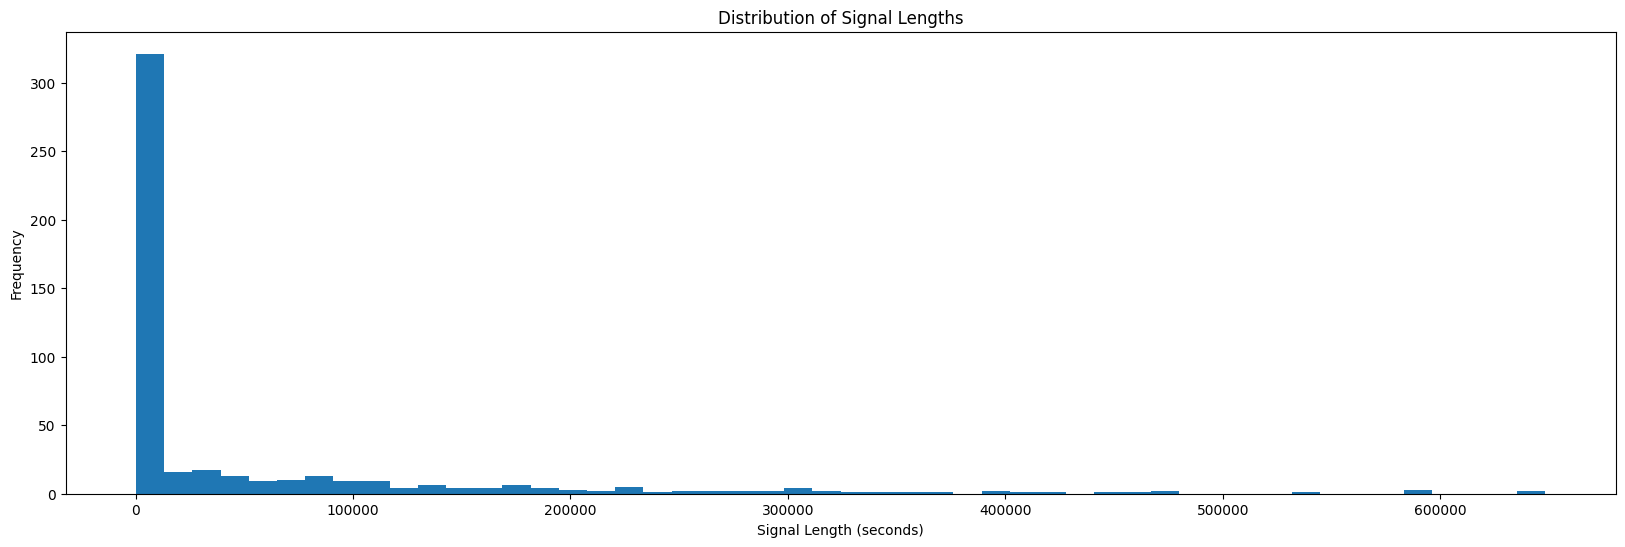

In [ ]:
# prompt: plot the distribution of df

plt.figure(figsize=(20, 6))
plt.hist(df_allfiles['length_signal_second'], bins=50)
plt.xlabel('Signal Length (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Signal Lengths')
plt.show()


In [ ]:
# prompt: what the duration of time is the most of signal length

most_frequent_length = df_allfiles['length_signal_second'].mode()[0]
print(f"The most frequent signal length is: {most_frequent_length} seconds")
#268.8

The most frequent signal length is: 268.8 seconds


In [ ]:
# prompt: how many signal have length from 30 to 50000

count_signals_30_500 = len(df_allfiles[(df_allfiles['length_signal_second'] >= 30) & (df_allfiles['length_signal_second'] <= 50000)])
print(f"Number of signals with length between 30 and 50000 seconds: {count_signals_30_500} / {len(all_files)}")
#366/490

Number of signals with length between 30 and 50000 seconds: 366 / 490


In [ ]:
# prompt: convert the length signal to categorical

bins = [0, 30, 120, 300, float('inf')]
labels = ['<30s', '30-120s', '120-300s', '>300s']

df_allfiles['length_signal_category'] = pd.cut(df_allfiles['length_signal_second'], bins=bins, labels=labels, include_lowest=True)

print(df_allfiles[['length_signal_second', 'length_signal_category']].head())


   length_signal_second length_signal_category
0                 880.0                  >300s
1                 268.8               120-300s
2                3260.8                  >300s
3                 268.8               120-300s
4                2972.8                  >300s


In [ ]:
# prompt: how many samples for each category

samples_per_category = df_allfiles.groupby('length_signal_category')['length_signal_second'].count()
print(samples_per_category)


length_signal_category
<30s          0
30-120s       0
120-300s    203
>300s       285
Name: length_signal_second, dtype: int64


<ipython-input-42-e35d40afaf0c>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples_per_category = df_allfiles.groupby('length_signal_category')['length_signal_second'].count()


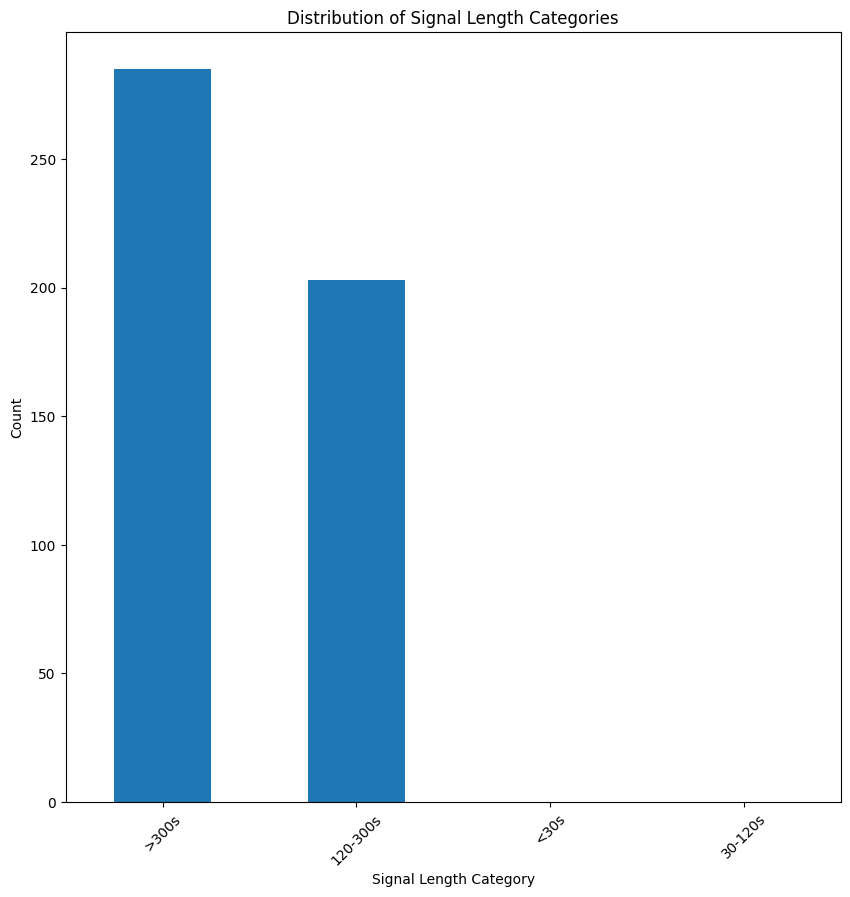

In [ ]:
# prompt: plot the length signal category

plt.figure(figsize=(10, 10))
df_allfiles['length_signal_category'].value_counts().plot(kind='bar')
plt.xlabel('Signal Length Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of Signal Length Categories')
plt.show()


In [ ]:
df_allfiles.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_allfiles.csv', index=False)

Conclusion:
- There are 490 files of signal, remove 2 file have 0 sample, now 488 files
- Total time: 7031.574166666666 hours
- Most of signal have length > 120 seconds

In [ ]:
df_allfiles = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_allfiles.csv')

#3. Get Data from PDF (Earthquake labeled)

In [ ]:
def extract_event_info(event):
  lines = event.strip().split('\n')
  event_number = int(lines[0])
  picked_arrival = re.search(r'Picked arrival: (.+)', event).group(1)
  tag = re.search(r'Tag : (.+)', event).group(1)
  arrival_type = re.search(r'Arrival type : (.+)', event).group(1)
  # Event parameters
  iris_event_id = re.search(r'IRIS Event ID : (\d+)', event).group(1)
  origin_time = re.search(r'Origin time : (.+)', event).group(1)
  latitude = re.search(r'Latitude : (.+)', event).group(1)
  longitude = re.search(r'Longitude : (.+)', event).group(1)
  depth = re.search(r'Depth : (.+)', event).group(1)
  magnitude = re.search(r'Magnitude : (.+)', event).group(1)
  return [event_number, picked_arrival, tag, arrival_type, iris_event_id, origin_time, latitude, longitude, depth, magnitude]

pdf_path = '/content/drive/MyDrive/MERMAIDAI/Pipatprathanporn+2021-SM1.pdf'

info = []
# Ouvrir le fichier PDF en mode binaire
with open(pdf_path, 'rb') as file:
    # Initialiser le lecteur PDF
    pdf_reader = PyPDF2.PdfReader(file)

    # Parcourir les pages du PDF
    for page_num in range(1, len(pdf_reader.pages)):  # Commencer à la deuxième page
        # Obtenir le contenu de la page
        page = pdf_reader.pages[page_num]
        page_content = page.extract_text()

        # Extraire la valeur de "Picked arrival"
        info_event = extract_event_info(page_content)
        info.append(info_event)

info = np.array(info)
df_labeled_earthquake = pd.DataFrame(info, columns=['Event number', 'Picked arrival', 'Tag', 'Arrival type', 'IRIS Event ID', 'Original time', 'Latitude', 'Longitude', 'Depth', 'Magnitude'])
df_labeled_earthquake

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude
0,1,2018-11-18 20:32:00.000,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.0000,6.80 Mww
1,2,2018-11-30 17:42:00.000,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.7000,7.00 mww
2,3,2018-12-05 04:26:35.000,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.0000,7.50 Mww
3,4,2018-12-11 02:38:40.000,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.6600,7.10 mww
4,5,2018-12-23 23:14:45.000,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.0000,6.40 mww
...,...,...,...,...,...,...,...,...,...,...
208,209,2019-08-02 01:26:00.000,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.0400,5.40 Mww
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.0000,4.90 mb
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.0000,5.90 Mww
211,212,2019-08-07 05:41:40.000,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.3000,5.80 Mww


##3.1 Some plots

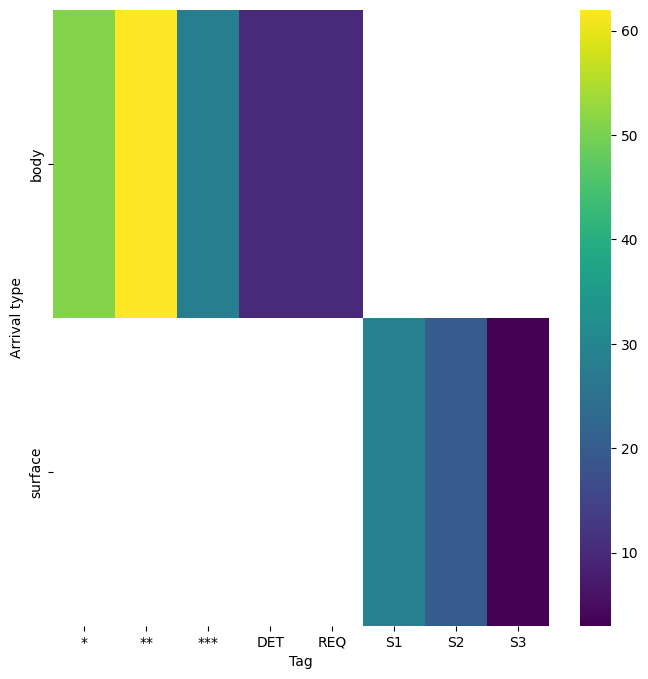

In [ ]:
# @title Tag vs Arrival type

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Arrival type'].value_counts()
    for x_label, grp in df_labeled_earthquake.groupby('Tag')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Tag')
_ = plt.ylabel('Arrival type')

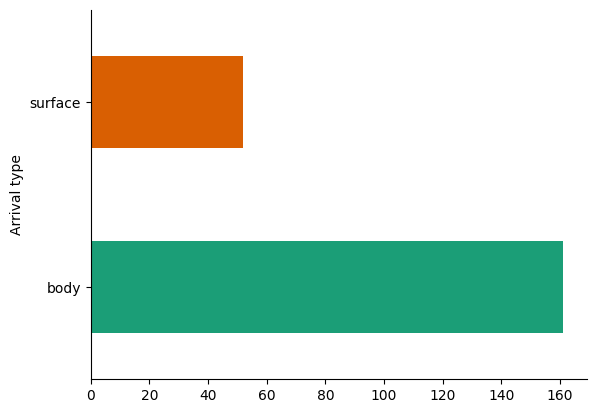

In [ ]:
# @title Arrival type

from matplotlib import pyplot as plt
import seaborn as sns
df_labeled_earthquake.groupby('Arrival type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

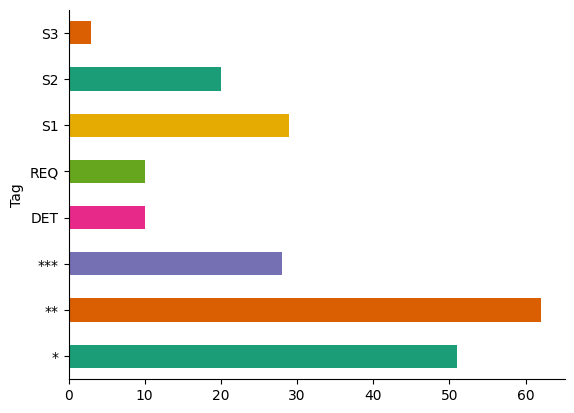

In [ ]:
# @title Tag

from matplotlib import pyplot as plt
import seaborn as sns
df_labeled_earthquake.groupby('Tag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##3.2 EDA

### Add infomations

In [ ]:
df_labeled_earthquake['Picked arrival'] = pd.to_datetime(df_labeled_earthquake['Picked arrival'], format='mixed', errors='coerce')
df_labeled_earthquake['Original time'] = pd.to_datetime(df_labeled_earthquake['Original time'], format='mixed', errors='coerce')
df_labeled_earthquake['Latitude'] = pd.to_numeric(df_labeled_earthquake['Latitude'], errors='coerce')
df_labeled_earthquake['Longitude'] = pd.to_numeric(df_labeled_earthquake['Longitude'], errors='coerce')
df_labeled_earthquake['Depth'] = pd.to_numeric(df_labeled_earthquake['Depth'], errors='coerce')
df_labeled_earthquake['Magnitude'] = df_labeled_earthquake['Magnitude'].str.replace(pat='mww', repl='', case=False,)
df_labeled_earthquake['Magnitude'] = pd.to_numeric(df_labeled_earthquake['Magnitude'], errors='coerce')
df_labeled_earthquake['file'] = ['vide' for _ in range(len(df_labeled_earthquake))]
df_labeled_earthquake['file_start'] = ['vide' for _ in range(len(df_labeled_earthquake))]
df_labeled_earthquake.head()

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start
0,1,2018-11-18 20:32:00,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,vide,vide
1,2,2018-11-30 17:42:00,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,vide,vide
2,3,2018-12-05 04:26:35,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,vide,vide
3,4,2018-12-11 02:38:40,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,vide,vide
4,5,2018-12-23 23:14:45,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,vide,vide


In [ ]:
# add file path

for i in tqdm(range(len(df_labeled_earthquake))):
    # print(i, '/', len(df))
    event_time = df_labeled_earthquake.loc[i,'Picked arrival']
    for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
        for fichier in fichiers:
            if fichier[0] == '2' :
                fichier_time = datetime.strptime(fichier[:19], '%Y-%m-%dT%H_%M_%S')
                fichier_time = fichier_time.replace(microsecond=0)
                if event_time >= fichier_time:
                        fs = 40
                        path = os.path.join(dossier_actuel, fichier)
                        y = np.fromfile(path, dtype=np.int32)
                        duree_sigal_s = int(len(y)/fs)
                        if (event_time - fichier_time).total_seconds() < duree_sigal_s:
                            if df_labeled_earthquake.loc[i,'file'] != 'vide':
                                print("Attention, deux fichiers pour l'événement {} !".format(i))
                            df_labeled_earthquake.loc[i,'file'] = path
                            df_labeled_earthquake.loc[i,'file_start'] = fichier_time
                            break
#25m35s

100%|██████████| 213/213 [20:11<00:00,  5.69s/it]


In [ ]:
# Check if all file is list
fichiers = df_labeled_earthquake['file'].to_numpy()
(fichiers == 'vide').sum()/len(fichiers)
#0

0.0

In [ ]:
# Add diff_start
df_labeled_earthquake['Picked arrival'] = pd.to_datetime(df_labeled_earthquake['Picked arrival'])
df_labeled_earthquake['file_start'] = pd.to_datetime(df_labeled_earthquake['file_start'])
diff_start = (df_labeled_earthquake['Picked arrival'] - df_labeled_earthquake['file_start']).dt.total_seconds()
df_labeled_earthquake['diff_start'] = diff_start

In [ ]:
# Add signal length in second
for i in tqdm(range(len(df_labeled_earthquake))):
    path = df_labeled_earthquake.loc[i,'file']
    # print(path)
    y = np.fromfile(path, dtype=np.int32)
    duree_sigal_s = int(len(y)/40)
    df_labeled_earthquake.loc[i,'length_signal_second'] = duree_sigal_s

100%|██████████| 213/213 [00:38<00:00,  5.48it/s]


In [ ]:
# Add diff_end
diff_end = (df_labeled_earthquake['length_signal_second'] - df_labeled_earthquake['diff_start'])
df_labeled_earthquake['diff_end'] = diff_end

In [ ]:
df_labeled_earthquake

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end
0,1,2018-11-18 20:32:00,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-18 01:22:16,68984.0,69161.0,177.0
1,2,2018-11-30 17:42:00,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-30 07:31:32,36628.0,36806.0,178.0
2,3,2018-12-05 04:26:35,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-02 02:26:15,266420.0,266691.0,271.0
3,4,2018-12-11 02:38:40,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-07 20:15:43,282177.0,282412.0,235.0
4,5,2018-12-23 23:14:45,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-23 20:19:50,10495.0,10681.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,2019-08-02 01:26:00,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.04,5.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-01 22:59:47,8773.0,73833.0,65060.0
209,210,2019-08-06 17:40:00,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.00,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0
210,211,2019-08-06 22:22:00,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.00,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0
211,212,2019-08-07 05:41:40,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.30,5.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,134218.0,204230.0,70012.0


In [ ]:
df_labeled_earthquake.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_labeled_earthquake.csv', index=False)

## 3.3. Labeled Earthquakes data from PDF

### 3.3.1 Check signals which have min/max duration from Arival picked to end

In [ ]:
df_allfiles = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_allfiles.csv')

In [ ]:
df_labeled_earthquake = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_labeled_earthquake.csv')

In [ ]:
# diff_end min
min = np.random.randint(0, np.max(df_labeled_earthquake['diff_end']))
for i in range(len(df_labeled_earthquake)):
  if df_labeled_earthquake['diff_end'][i] < min:
    min = df_labeled_earthquake['diff_end'][i]
    i_min = i
print(i_min)  #0
print(min)  #177

0
177.0


In [ ]:
# diff_end max
max = np.random.randint(0, np.max(df_labeled_earthquake['diff_end']))
for i in range(len(df_labeled_earthquake)):
  if df_labeled_earthquake['diff_end'][i] > max:
    max = df_labeled_earthquake['diff_end'][i]
    i_max = i
print(i_max)  #147
print(max)  #615326.0

147
615326.0


In [ ]:
y0 = np.fromfile(df_labeled_earthquake['file'][0], dtype=np.int32)
y147 = np.fromfile(df_labeled_earthquake['file'][147], dtype=np.int32)
y0_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y0, 100)))))
y147_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y147, 100)))))

Text(0, 0.5, 'amplitude')

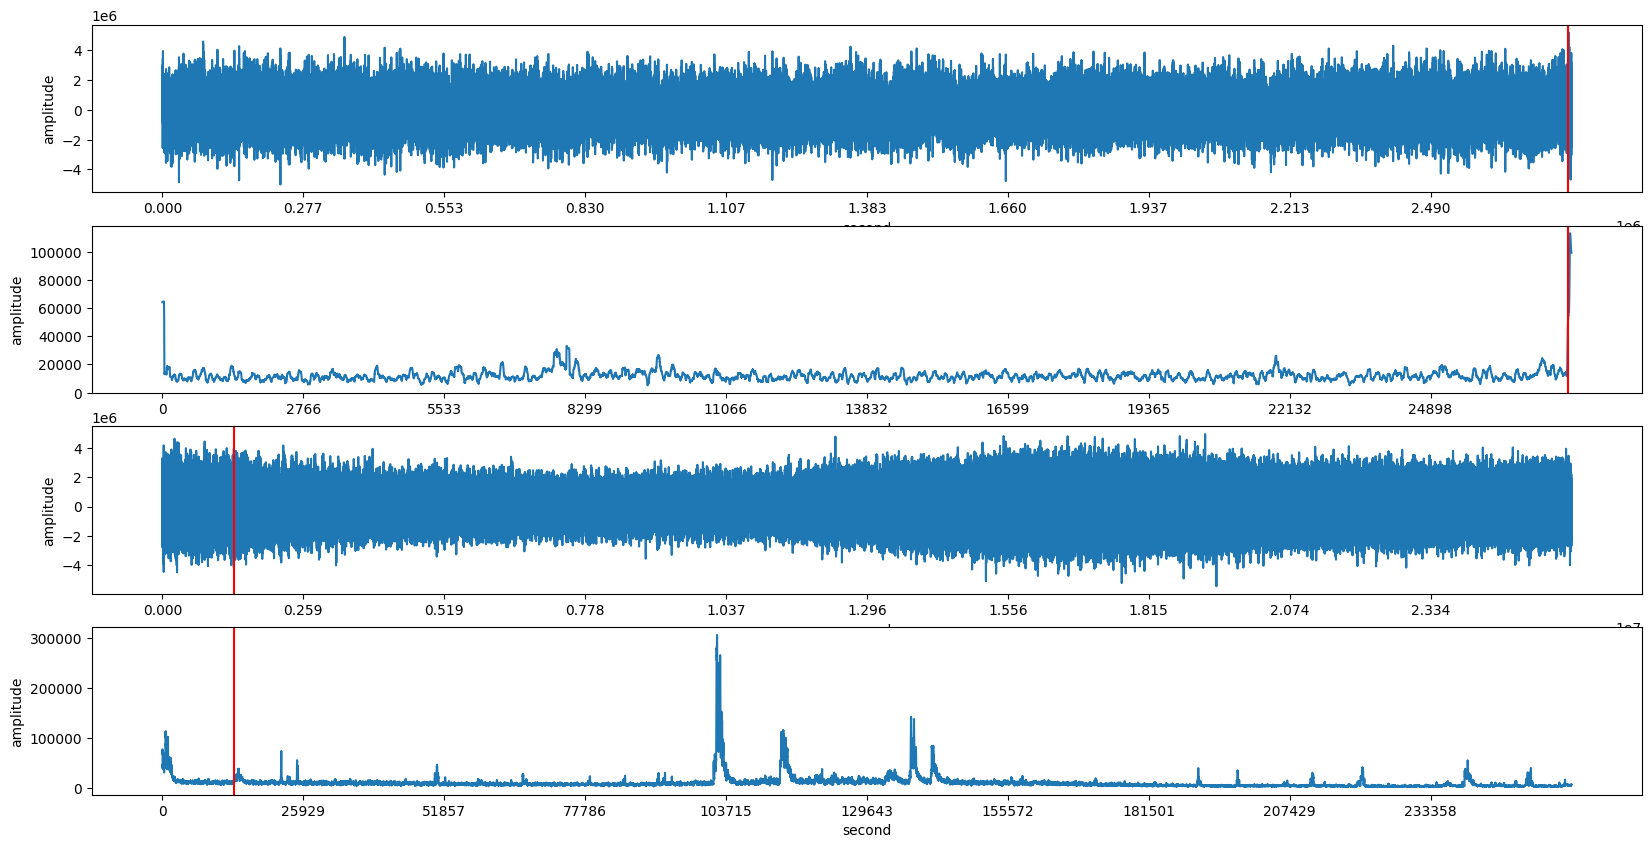

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.plot(y0)
plt.axvline(df_labeled_earthquake['diff_start'][0]*40, color='r')
plt.xticks(np.arange(0, df_labeled_earthquake['length_signal_second'][0]*40, step=df_labeled_earthquake['length_signal_second'][0]*40/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 2)
plt.plot(y0_filtered)
plt.axvline(df_labeled_earthquake['diff_start'][0]*40/100, color='r')
plt.xticks(np.arange(0, df_labeled_earthquake['length_signal_second'][0]*40/100, step=df_labeled_earthquake['length_signal_second'][0]*40/100/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 3)
plt.plot(y147)
plt.axvline(df_labeled_earthquake['diff_start'][147]*40, color='r')
plt.xticks(np.arange(0, df_labeled_earthquake['length_signal_second'][147]*40, step=df_labeled_earthquake['length_signal_second'][147]*40/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 4)
plt.plot(y147_filtered)
plt.axvline(df_labeled_earthquake['diff_start'][147]*40/100, color='r')
plt.xticks(np.arange(0, df_labeled_earthquake['length_signal_second'][147]*40/100, step=df_labeled_earthquake['length_signal_second'][147]*40/100/10))
plt.xlabel('second')
plt.ylabel('amplitude')

###3.3.2 Handle duplicate files

In [ ]:
df_labeled_earthquake = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_labeled_earthquake.csv')
df_labeled_earthquake

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end
0,1,2018-11-18 20:32:00.000,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-18 01:22:16,68984.0,69161.0,177.0
1,2,2018-11-30 17:42:00.000,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-30 07:31:32,36628.0,36806.0,178.0
2,3,2018-12-05 04:26:35.000,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-02 02:26:15,266420.0,266691.0,271.0
3,4,2018-12-11 02:38:40.000,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-07 20:15:43,282177.0,282412.0,235.0
4,5,2018-12-23 23:14:45.000,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-23 20:19:50,10495.0,10681.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,2019-08-02 01:26:00.000,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.04,5.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-01 22:59:47,8773.0,73833.0,65060.0
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.00,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.00,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0
211,212,2019-08-07 05:41:40.000,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.30,5.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,134218.0,204230.0,70012.0


In [ ]:
# prompt: create a dataframe consist all row of df_labeled_earthquake have value of file appear more than 2 time

# Count the occurrences of each file path
file_counts = df_labeled_earthquake['file'].value_counts()

# Filter out rows where the file path appears more than 2 times
files_more_than_2 = file_counts[file_counts >= 2].index.tolist()

# Create a new DataFrame with rows where the file path is in the filtered list
df_filtered_earthquake = df_labeled_earthquake[df_labeled_earthquake['file'].isin(files_more_than_2)]


In [ ]:
df_duplicated_files = df_filtered_earthquake.sort_values('file')

In [ ]:
# prompt: number each group of row with the same file value of df_duplicated_files

# Assuming df_duplicated_files is your DataFrame

df_duplicated_files['group_number'] = (df_duplicated_files['file'] != df_duplicated_files['file'].shift()).cumsum()

In [ ]:
df_duplicated_files

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end,group_number
134,135,2018-09-15 16:38:00.000,*,body,10948285,2018-09-15 16:24:34.810,26.5742,129.5279,10.2,5.6,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,4524.0,116771.0,112247.0,1
20,21,2018-09-16 21:18:05.000,***,body,10948555,2018-09-16 21:11:48.820,-25.4210,178.2059,576.0,6.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,107729.0,116771.0,9042.0,1
138,139,2018-09-28 07:17:00.000,*,body,10953041,2018-09-28 07:03:18.350,-0.2102,120.0175,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-27 02:54:39,102141.0,226665.0,124524.0,2
21,22,2018-09-28 10:16:30.000,***,body,10953070,2018-09-28 10:02:43.480,-0.1781,119.8401,10.0,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-27 02:54:39,112911.0,226665.0,113754.0,2
140,141,2018-10-02 10:17:20.000,*,body,10954594,2018-10-02 10:08:37.460,-17.8250,167.8506,10.0,5.6,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-10-01 16:15:20,64920.0,87945.0,23025.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,130,2019-08-04 10:36:30.000,**,body,11091618,2019-08-04 10:23:03.736,37.7597,141.6089,38.0,6.3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-03 17:57:45,59925.0,167203.0,107278.0,52
130,131,2019-08-05 09:07:20.000,**,body,11092028,2019-08-05 09:01:08.554,-19.3534,-174.8786,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-03 17:57:45,140975.0,167203.0,26228.0,52
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.0,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0,53
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0,53


In [ ]:
# prompt: create sub data frames, each one have the row have the same group_number

# Assuming df_duplicated_files is your DataFrame with the 'group_number' column

# Create a dictionary to store the sub-DataFrames
sub_dfs = {}

# Iterate through the unique group numbers
for group_number in df_duplicated_files['group_number'].unique():
  # Filter the DataFrame based on the current group number
  sub_df = df_duplicated_files[df_duplicated_files['group_number'] == group_number]

  # Store the sub-DataFrame in the dictionary
  sub_dfs[group_number] = sub_df.sort_values('diff_start')

# Now you have a dictionary 'sub_dfs' where keys are group numbers and values are corresponding sub-DataFrames
# You can access a specific sub-DataFrame like this:
# sub_dfs[1]  # This will give you the DataFrame for group number 1


In [ ]:
sub_dfs[53]

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end,group_number
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0,53
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.0,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0,53
211,212,2019-08-07 05:41:40.000,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.3,5.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,134218.0,204230.0,70012.0,53


In [ ]:
sub_dfs[1]

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end,group_number
134,135,2018-09-15 16:38:00.000,*,body,10948285,2018-09-15 16:24:34.810,26.5742,129.5279,10.2,5.6,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,4524.0,116771.0,112247.0,1
20,21,2018-09-16 21:18:05.000,***,body,10948555,2018-09-16 21:11:48.820,-25.4210,178.2059,576.0,6.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,107729.0,116771.0,9042.0,1


In [ ]:
for i in tqdm(range(1, len(sub_dfs)+1)):
  # y = np.fromfile(sub_dfs[i]['file'].iloc[0], dtype=np.int32)
  num_arrival = len(sub_dfs[i])

  arrival =[]
  for j in range(num_arrival):
    arrival.append(sub_dfs[i]['diff_start'].iloc[j])
  # print(arrival)

  central = []
  for j in range(0,len(arrival)-1):
    central.append((arrival[j] +arrival[j+1])/2)
  central.append(sub_dfs[i]['length_signal_second'].iloc[0])
  central.insert(0, 0)
  # print(central)

  y = np.fromfile(sub_dfs[i]['file'].iloc[0], dtype=np.int32)
  new_diff_start = []
  new_file = []
  new_length_signal_second = []
  for j in range(num_arrival):
    sub_y = (y[int(central[j]*40):int(central[j+1]*40)])
    new_diff_start.append(arrival[j] - central[j])
    new_length_signal_second.append(central[j+1] - central[j])
    new_file.append(sub_dfs[i]['file'].iloc[0].split('.')[0] + '_' + str(j) + '.txt')
    sub_y.tofile(new_file[j])
    j += 1

  for j in range(num_arrival):
    sub_dfs[i]['file'].iloc[j] = new_file[j]
    sub_dfs[i]['diff_start'].iloc[j] = new_diff_start[j]
    sub_dfs[i]['length_signal_second'].iloc[j] = new_length_signal_second[j]
    # sub_dfs[i]['new_diff_start'].iloc[j] = new_diff_start[j]
    # sub_dfs[i]['new_file'].iloc[j] = new_file[j]

Streaming output truncated to the last 5000 lines.
  sub_dfs[i]['length_signal_second'].iloc[j] = new_length_signal_second[j]
<ipython-input-13-ce493b46789c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dfs[i]['length_signal_second'].iloc[j] = new_length_signal_second[j]
 34%|███▍      | 18/53 [01:40<03:16,  5.62s/it]<ipython-input-13-ce493b46789c>:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting value

In [ ]:

# prompt: add column new_file to df_duplicated_files, value from sub_dfs

# Assuming df_duplicated_files and sub_dfs are defined as in your code

df_duplicated_files['new_file'] = ' '  # Initialize a new column with empty strings


for group_number in tqdm(range(1, len(sub_dfs) + 1)):
  for j in range(len(sub_dfs[group_number])):
    new_file_name = sub_dfs[group_number]['file']
    new_diff_start = sub_dfs[group_number]['diff_start']
    new_length_signal_second = sub_dfs[group_number]['length_signal_second']
    df_duplicated_files.loc[
        (df_duplicated_files['group_number'] == group_number) &
        (df_duplicated_files.index == sub_dfs[group_number].index[j]),
        'new_file'] = new_file_name
    df_duplicated_files.loc[
        (df_duplicated_files['group_number'] == group_number) &
        (df_duplicated_files.index == sub_dfs[group_number].index[j]),
        'new_diff_start'] = new_diff_start
    df_duplicated_files.loc[
        (df_duplicated_files['group_number'] == group_number) &
        (df_duplicated_files.index == sub_dfs[group_number].index[j]),
        'new_length_signal_second'] = new_length_signal_second

100%|██████████| 53/53 [00:00<00:00, 112.16it/s]


In [ ]:
df_duplicated_files

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end,group_number,new_file,new_diff_start,new_length_signal_second
134,135,2018-09-15 16:38:00.000,*,body,10948285,2018-09-15 16:24:34.810,26.5742,129.5279,10.2,5.6,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,4524.0,116771.0,112247.0,1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,4524.0,56126.5
20,21,2018-09-16 21:18:05.000,***,body,10948555,2018-09-16 21:11:48.820,-25.4210,178.2059,576.0,6.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-15 15:22:36,107729.0,116771.0,9042.0,1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,51602.5,60644.5
138,139,2018-09-28 07:17:00.000,*,body,10953041,2018-09-28 07:03:18.350,-0.2102,120.0175,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-27 02:54:39,102141.0,226665.0,124524.0,2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,102141.0,107526.0
21,22,2018-09-28 10:16:30.000,***,body,10953070,2018-09-28 10:02:43.480,-0.1781,119.8401,10.0,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-09-27 02:54:39,112911.0,226665.0,113754.0,2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,5385.0,119139.0
140,141,2018-10-02 10:17:20.000,*,body,10954594,2018-10-02 10:08:37.460,-17.8250,167.8506,10.0,5.6,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-10-01 16:15:20,64920.0,87945.0,23025.0,3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,18130.0,41155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,130,2019-08-04 10:36:30.000,**,body,11091618,2019-08-04 10:23:03.736,37.7597,141.6089,38.0,6.3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-03 17:57:45,59925.0,167203.0,107278.0,52,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,59925.0,100450.0
130,131,2019-08-05 09:07:20.000,**,body,11092028,2019-08-05 09:01:08.554,-19.3534,-174.8786,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-03 17:57:45,140975.0,167203.0,26228.0,52,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,40525.0,66753.0
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.0,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0,53,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,8460.0,21650.0
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.0,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0,53,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,90918.0,99378.0


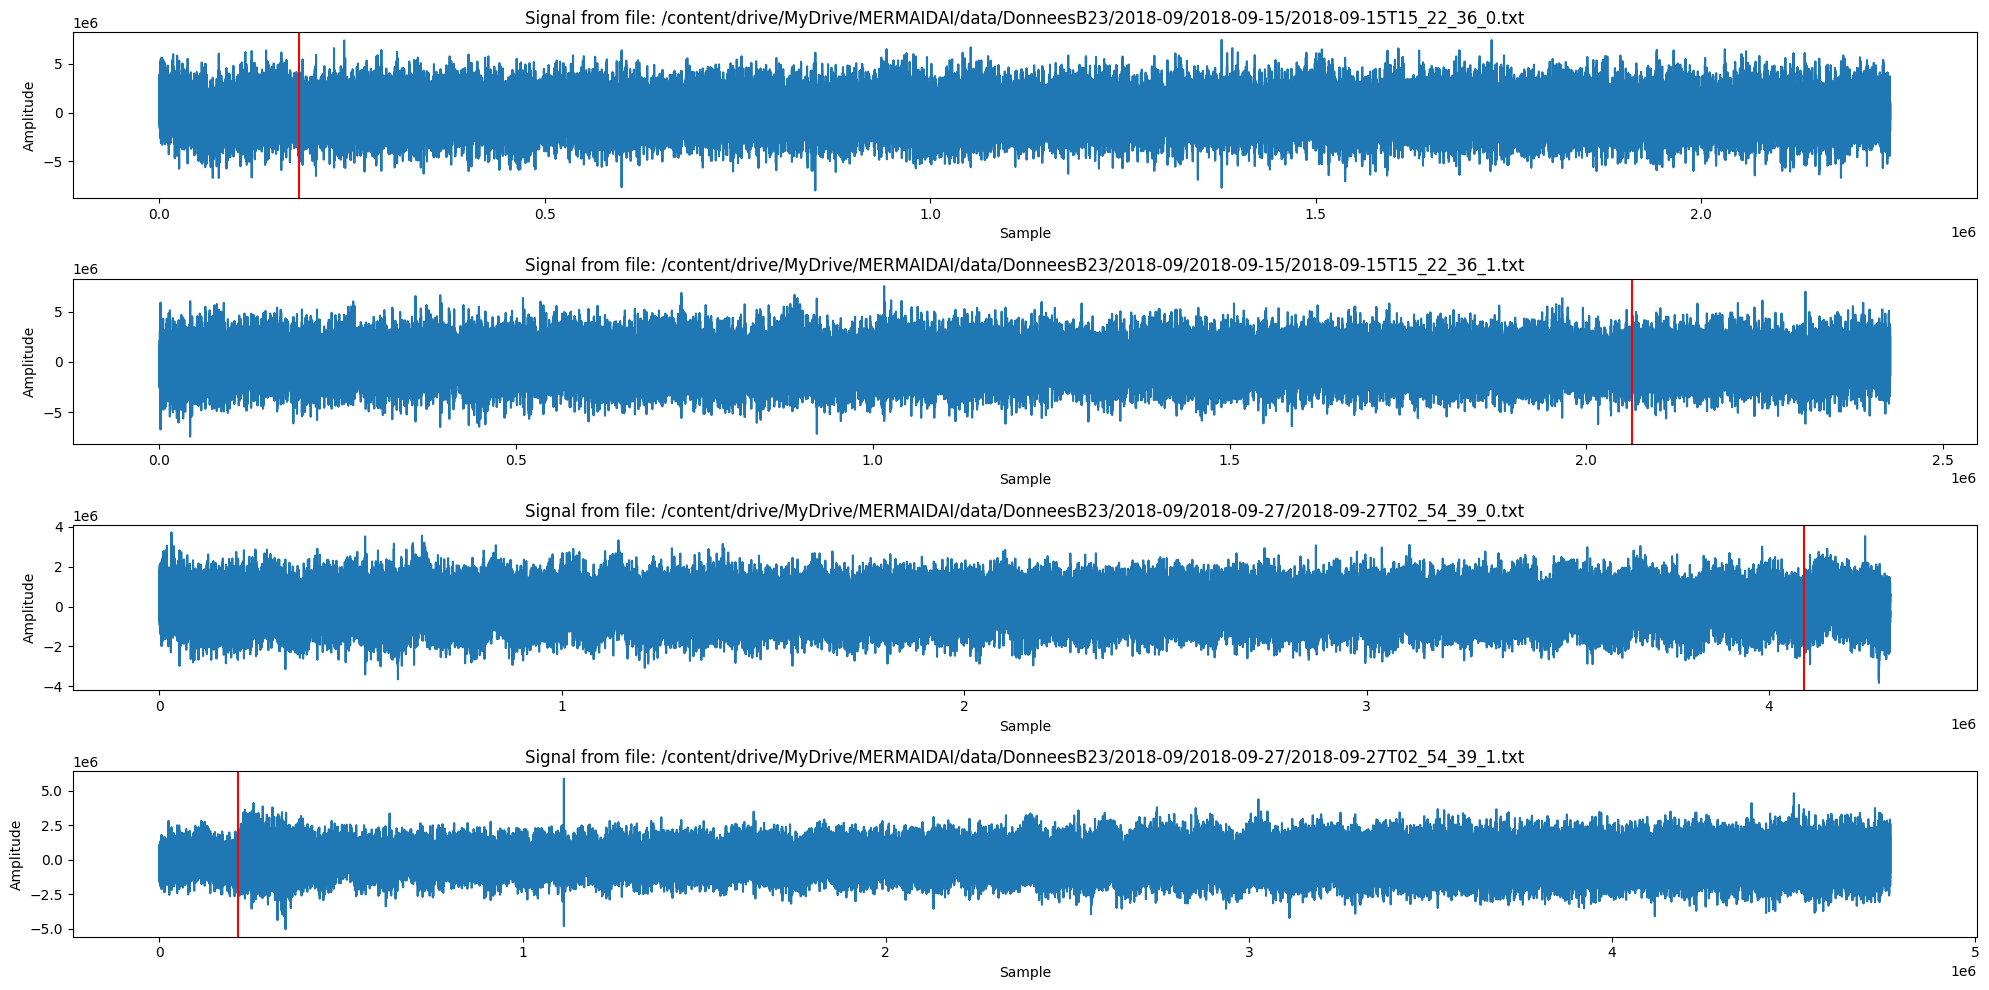

In [ ]:
# prompt: plot the first 4 signal from df_duplicated_files

# Assuming df_duplicated_files is defined and contains the necessary data
# and you want to plot the first 4 signals

plt.figure(figsize=(20, 10))

for i in range(min(4, len(df_duplicated_files))):
  file_path = df_duplicated_files['new_file'].iloc[i]
  diff_start = df_duplicated_files['new_diff_start'].iloc[i]
  y = np.fromfile(file_path, dtype=np.int32)

  plt.subplot(4, 1, i + 1)
  plt.plot(y)
  plt.axvline(diff_start*40, color='r')
  plt.title(f"Signal from file: {file_path}")
  plt.xlabel("Sample")
  plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
# prompt: save df_duplicated_files

# Assuming df_duplicated_files is your DataFrame
df_duplicated_files.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_duplicated_files.csv', index=False)

In [ ]:
# prompt: change value of file, diff_start, length_signal_second in df_labeled_earthquake by value of new_file, new_diff_start, new_length_signal_second in df_duplicated_files, if each row has the same value of Event number

# Assuming df_labeled_earthquake and df_duplicated_files are defined
# and you want to update values in df_labeled_earthquake based on
# df_duplicated_files for rows with the same 'Event number'

for event_number in df_duplicated_files['Event number'].unique():
  # Get rows from both DataFrames for the current event number
  df_labeled_rows = df_labeled_earthquake[
      df_labeled_earthquake['Event number'] == event_number]
  df_duplicated_rows = df_duplicated_files[
      df_duplicated_files['Event number'] == event_number]

  # Iterate through the rows in df_labeled_rows and update values
  for index_labeled in df_labeled_rows.index:
    matching_row = df_duplicated_rows[
        df_duplicated_rows.index == index_labeled]
    if not matching_row.empty:
      df_labeled_earthquake.loc[index_labeled, 'file'] = matching_row['new_file'].iloc[0]
      df_labeled_earthquake.loc[index_labeled, 'diff_start'] = matching_row['new_diff_start'].iloc[0]
      df_labeled_earthquake.loc[index_labeled, 'length_signal_second'] = matching_row['new_length_signal_second'].iloc[0]

# Now df_labeled_earthquake has updated values based on df_duplicated_files

In [ ]:
df_labeled_earthquake.to_csv('/content/drive/MyDrive/MERMAIDAI/data/procced_df_labeled_earthquake.csv', index=False)

###3.3.3 Check unique

In [ ]:
# prompt: get a df_unique_file from df_labeled_earthquake with file is unique

df_unique_file = df_labeled_earthquake.drop_duplicates(subset=['file'], keep='first')
df_unique_file = df_unique_file[['Event number', 'file', 'length_signal_second']].sort_values('file')
df_unique_file

,Event number,file,length_signal_second
133,134,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,87644.0
20,21,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,116771.0
135,136,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,90646.0
136,137,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,40803.0
137,138,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,203539.0
...,...,...,...
129,130,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,167203.0
209,210,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,204230.0
131,132,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,78601.0
212,213,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,172604.0


In [ ]:
# prompt: sum length_signal_second of df_unique_file

total_length_signal_unique_files = df_unique_file['length_signal_second'].sum()
print(f"Total length of signal (unique files): {total_length_signal_unique_files/3600} hours")
#5498.4991666666665

Total length of signal (unique files): 5498.4991666666665 hours


In [ ]:
# prompt: add a column to df_allfifles, the value is 'labeled' if file_path is consist of df_labeled_earthquake, and 'notlabeled' if not

df_allfiles['labeled'] = 'unlabeled'
for i in range(len(df_allfiles)):
    if df_allfiles['file_path'][i] in df_labeled_earthquake['file'].values:
        df_allfiles['labeled'][i] = 'labeled'



<ipython-input-67-b5b0c2cb1d5b>:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_allfiles['labeled'][i] = 'labeled'
<ipython-input-67-b5b0c2cb1d5b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
# prompt: how many labeled in df_allfiles

labeled_count = (df_allfiles['labeled'] == 'labeled').sum()
print(f"Number of labeled signals in df_allfiles: {labeled_count}")
#103

Number of labeled signals in df_allfiles: 103


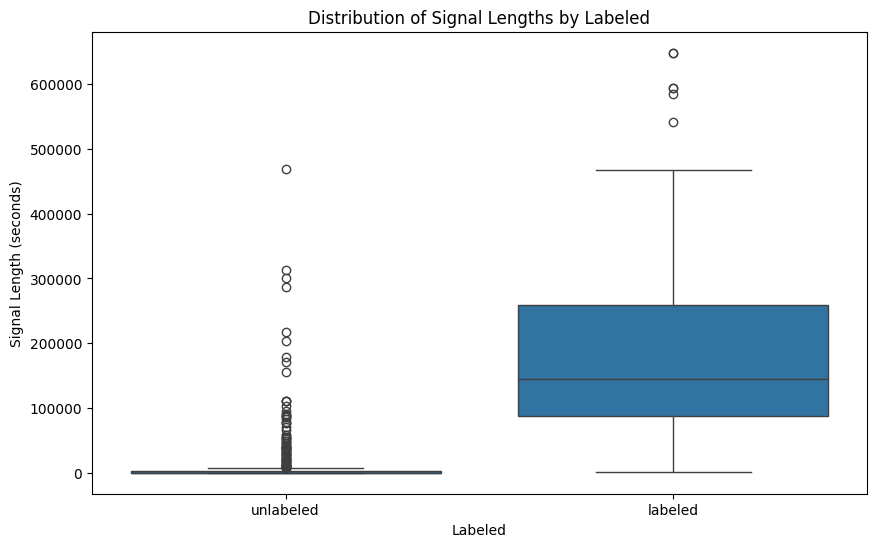

In [ ]:
# prompt: plot length_signal_second by labeled

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='labeled', y='length_signal_second', data=df_allfiles)
plt.xlabel('Labeled')
plt.ylabel('Signal Length (seconds)')
plt.title('Distribution of Signal Lengths by Labeled')
plt.show()


In [ ]:
# prompt: sum of length_signal_second of labeled and notlabeled

labeled_signal_sum = df_allfiles[df_allfiles['labeled'] == 'labeled']['length_signal_second'].sum()
unlabeled_signal_sum = df_allfiles[df_allfiles['labeled'] == 'unlabeled']['length_signal_second'].sum()

print(f"Sum of length_signal_second for labeled signals: {labeled_signal_sum/3600}")  #5498.511111111111
print(f"Sum of length_signal_second for unlabeled signals: {unlabeled_signal_sum/3600}")  #1533.127111111111


Sum of length_signal_second for labeled signals: 5498.511111111111
Sum of length_signal_second for unlabeled signals: 1533.127111111111


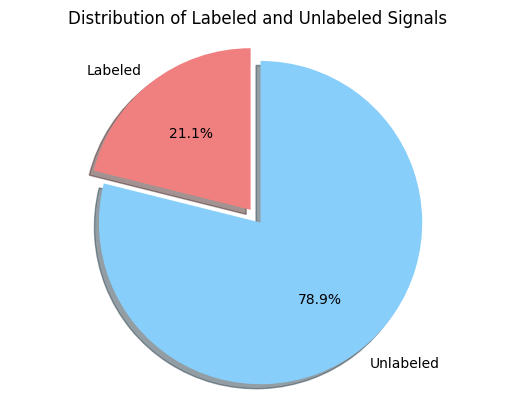

In [ ]:
# prompt: plot pie of labeled

import matplotlib.pyplot as plt

# Count the number of labeled and unlabeled signals
labeled_count = (df_allfiles['labeled'] == 'labeled').sum()
unlabeled_count = (df_allfiles['labeled'] == 'unlabeled').sum()

# Create the pie chart
labels = ['Labeled', 'Unlabeled']
sizes = [labeled_count, unlabeled_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 'Labeled' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Labeled and Unlabeled Signals')
plt.show()


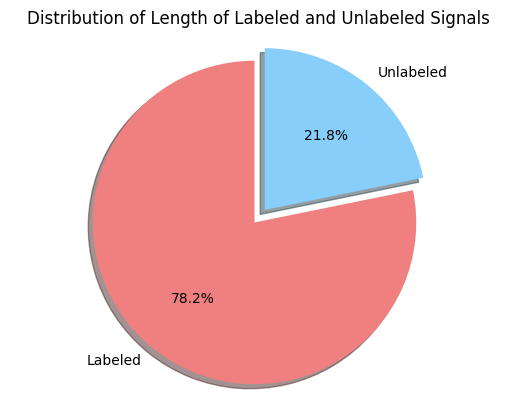

In [ ]:
# prompt: plot pie of length of labeled

# Calculate the total length of labeled and unlabeled signals
labeled_length_sum = df_allfiles[df_allfiles['labeled'] == 'labeled']['length_signal_second'].sum()
unlabeled_length_sum = df_allfiles[df_allfiles['labeled'] == 'unlabeled']['length_signal_second'].sum()

# Create the pie chart
labels = ['Labeled', 'Unlabeled']
sizes = [labeled_length_sum, unlabeled_length_sum]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 'Labeled' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Length of Labeled and Unlabeled Signals')
plt.show()


In [ ]:
df_allfiles.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_allfiles.csv', index=False)

#4. Get Data from notlabeled files

In [ ]:
# prompt: create a dataframe from df_allfiles consist file_path and length_signal_second which unlabeled

df_notlabeled_files = df_allfiles[df_allfiles['labeled'] == 'unlabeled'][['file_path', 'length_signal_second']]
df_notlabeled_files

,file_path,length_signal_second
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,880.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.8
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,3260.8
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.8
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2972.8
...,...,...
481,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.6
482,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2672.0
483,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.6
484,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,556.8


In [ ]:
# prompt: total length

total_length = df_notlabeled_files['length_signal_second'].sum()
print(f"Total length of unlabeled signals: {total_length/3600}")
#1533.127111111111

Total length of unlabeled signals: 1533.127111111111


In [ ]:
# prompt: save df_notlabeled

df_notlabeled_files.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_notlabeled_files.csv', index=False)


In [ ]:
df_notlabeled_files = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_notlabeled_files.csv')

##4.1 EDA

In [ ]:
# prompt: describe plots of df_notlabeled_files

# Describe plots of df_notlabeled_files

# We can analyze the distribution of signal lengths in the unlabeled dataset using the following plots:


# 1. Histogram of Signal Lengths:
#    - `plt.hist(df_notlabeled_files['length_signal_second'], bins=50)`
#    - This plot shows the frequency distribution of the signal lengths in the unlabeled dataset. It allows us to observe the common lengths and identify potential outliers.

# 2. Boxplot of Signal Lengths:
#    - `sns.boxplot(y='length_signal_second', data=df_notlabeled_files)`
#    - The boxplot visualizes the distribution of signal lengths including the median, quartiles, and potential outliers. It gives a good overview of the central tendency and spread of the data.

# 3. Signal Length Category Distribution (Bar Plot):
#    - `df_notlabeled_files['length_signal_category'].value_counts().plot(kind='bar')` (Assuming 'length_signal_category' is defined similarly to the labeled dataset)
#    - If signal lengths are categorized (e.g., short, medium, long), a bar plot can show the number of signals within each category. It helps understand how many signals belong to specific length ranges.

# In addition to these basic plots, we can also consider:

# - Comparing the Distribution of Unlabeled and Labeled Signals:
#   - Create a boxplot or histogram comparing the 'length_signal_second' distributions of `df_notlabeled_files` and `df_allfiles` (filtered for labeled signals). This comparison would help identify differences in the length distributions between the labeled and unlabeled datasets.
# - Time-Series Plots:
#   - Visualize the raw signal data from a few randomly selected files from `df_notlabeled_files`. This would provide a visual understanding of the characteristic patterns of the unlabeled data.
# - Feature Analysis:
#   - If we have calculated other features from the unlabeled signals (e.g., frequency spectrum, amplitude statistics), we can plot the distribution of these features to identify unique characteristics of the unlabeled dataset.


# These plots will help you analyze the `df_notlabeled_files` and understand the distribution of signal lengths in the unlabeled data, which can be beneficial for training a model or further data exploration.

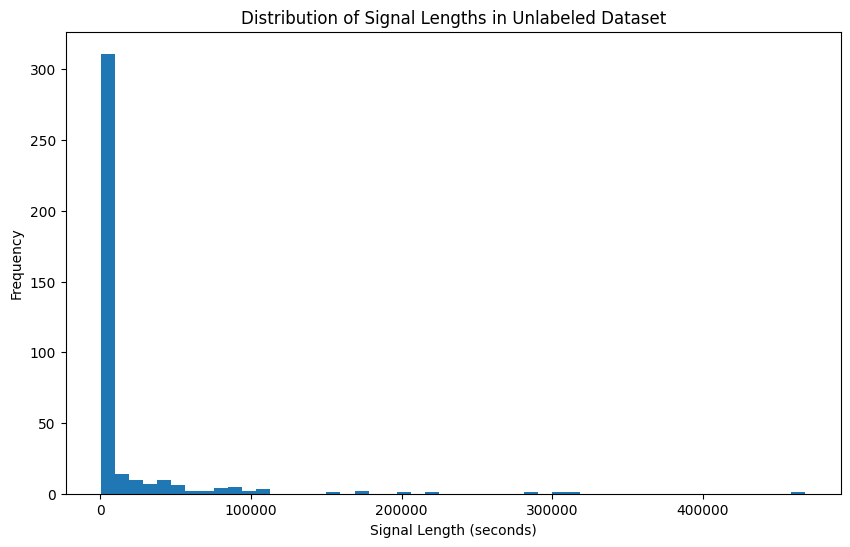

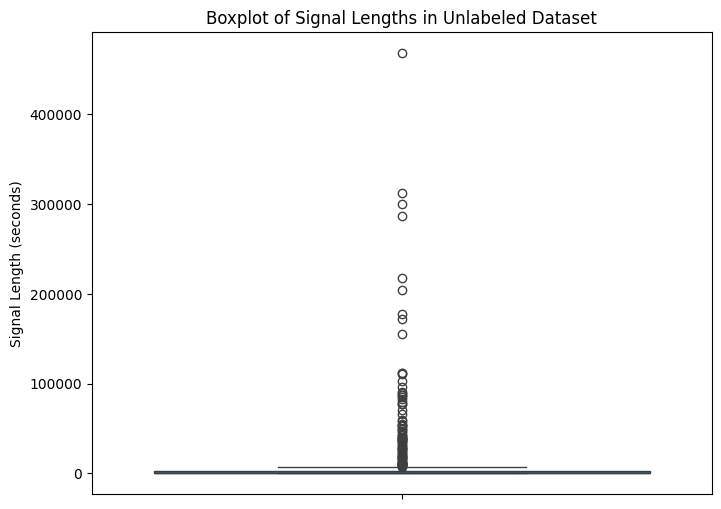

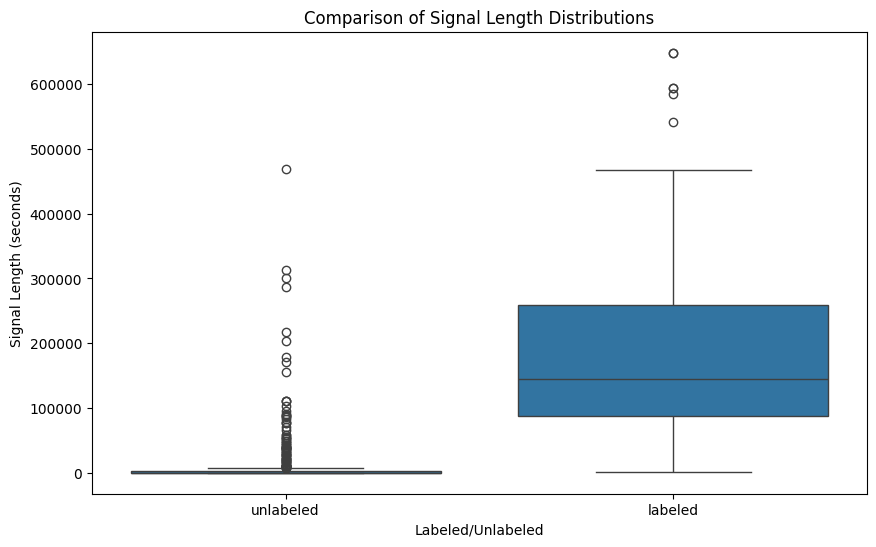

In [ ]:
# prompt: plot some describe plots of df_notlabeled_files

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogram of Signal Lengths
plt.figure(figsize=(10, 6))
plt.hist(df_notlabeled_files['length_signal_second'], bins=50)
plt.xlabel('Signal Length (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Signal Lengths in Unlabeled Dataset')
plt.show()


# 2. Boxplot of Signal Lengths
plt.figure(figsize=(8, 6))
sns.boxplot(y='length_signal_second', data=df_notlabeled_files)
plt.ylabel('Signal Length (seconds)')
plt.title('Boxplot of Signal Lengths in Unlabeled Dataset')
plt.show()


# 3. Signal Length Category Distribution (Assuming 'length_signal_category' is defined)
# If you have a 'length_signal_category' column in df_notlabeled_files
# plt.figure(figsize=(10, 6))
# df_notlabeled_files['length_signal_category'].value_counts().plot(kind='bar')
# plt.xlabel('Signal Length Category')
# plt.ylabel('Count')
# plt.title('Distribution of Signal Length Categories in Unlabeled Dataset')
# plt.show()


# Compare Distribution of Unlabeled and Labeled Signals (Example with Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='labeled', y='length_signal_second', data=df_allfiles)
plt.xlabel('Labeled/Unlabeled')
plt.ylabel('Signal Length (seconds)')
plt.title('Comparison of Signal Length Distributions')
plt.show()

##4.2 Check data notlabeled


In [ ]:
# prompt: get index file have length min and max in df_notlabeled_files

min_length_index = df_notlabeled_files['length_signal_second'].idxmin()
max_length_index = df_notlabeled_files['length_signal_second'].idxmax()

print(f"Index of file with minimum length: {min_length_index}") #51
print(f"Index of file with maximum length: {max_length_index}") #161


Index of file with minimum length: 51
Index of file with maximum length: 161


In [ ]:
# prompt: length of min and max

min_length = df_notlabeled_files['length_signal_second'].min()
max_length = df_notlabeled_files['length_signal_second'].max()

print(f"Minimum length: {min_length}")  #256
print(f"Maximum length: {max_length}")  #468073.6


Minimum length: 256.0
Maximum length: 468073.6


In [ ]:
y51 = np.fromfile(df_notlabeled_files['file_path'][51], dtype=np.int32)
y161 = np.fromfile(df_notlabeled_files['file_path'][161], dtype=np.int32)
y51_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y51, 100)))))
y161_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y161, 100)))))

Text(0, 0.5, 'amplitude')

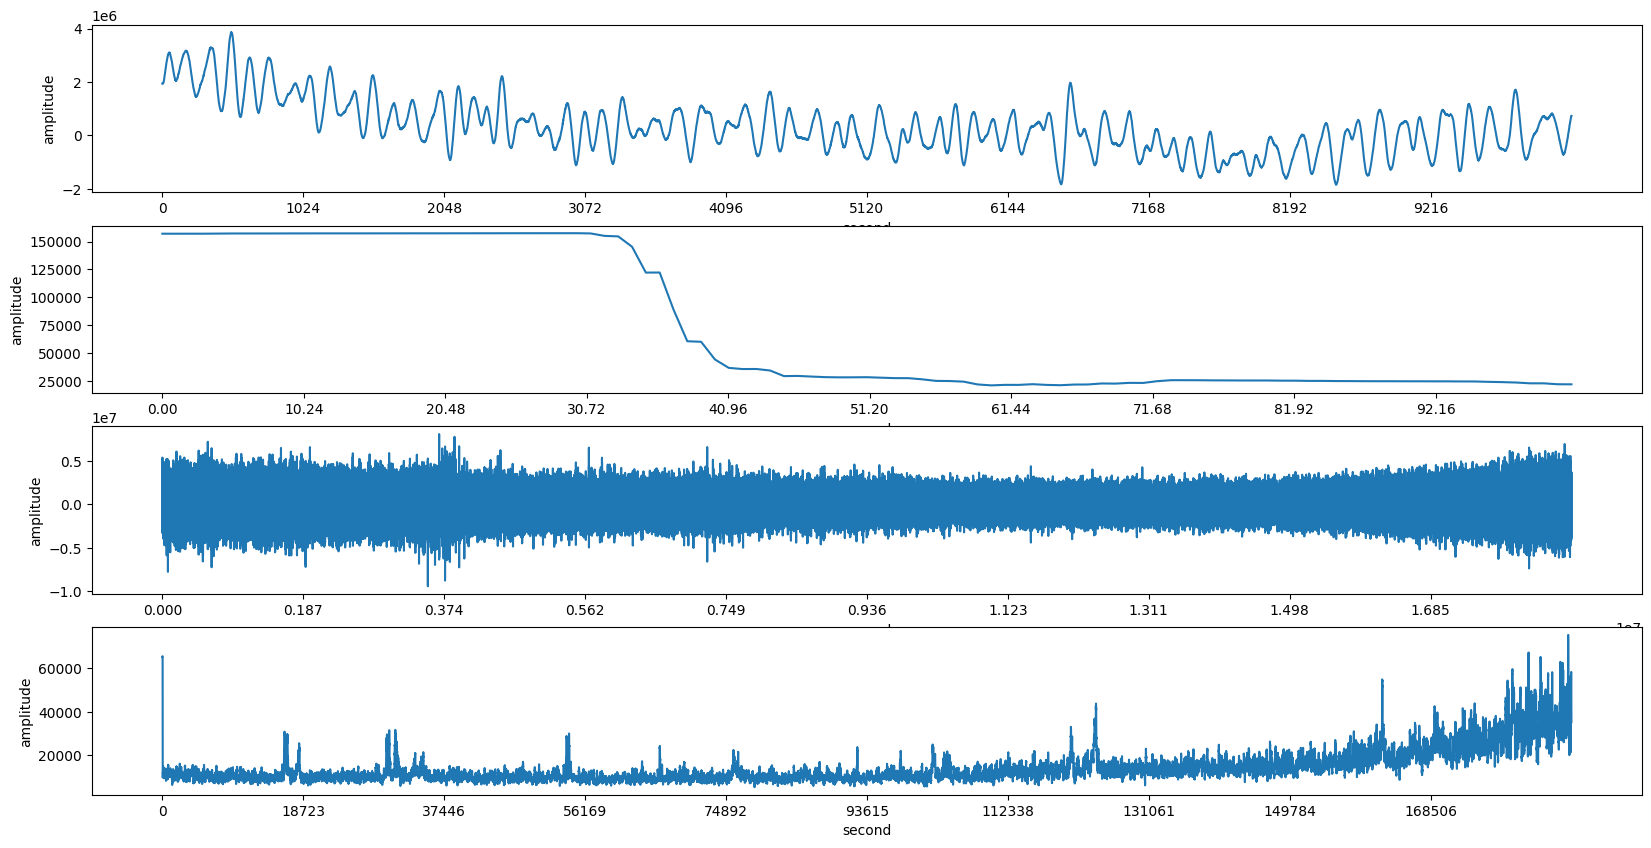

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.plot(y51)
plt.xticks(np.arange(0, df_notlabeled_files['length_signal_second'][51]*40, step=df_notlabeled_files['length_signal_second'][51]*40/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 2)
plt.plot(y51_filtered)
plt.xticks(np.arange(0, df_notlabeled_files['length_signal_second'][51]*40/100, step=df_notlabeled_files['length_signal_second'][51]*40/100/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 3)
plt.plot(y161)
plt.xticks(np.arange(0, df_notlabeled_files['length_signal_second'][161]*40, step=df_notlabeled_files['length_signal_second'][161]*40/10))
plt.xlabel('second')
plt.ylabel('amplitude')

plt.subplot(4, 1, 4)
plt.plot(y161_filtered)
plt.xticks(np.arange(0, df_notlabeled_files['length_signal_second'][161]*40/100, step=df_notlabeled_files['length_signal_second'][161]*40/100/10))
plt.xlabel('second')
plt.ylabel('amplitude')